### Excercise 9.7.4
In this excercise we extend the ATE study of the 401k data (see notebook 9.6.3) to cover the GATE for low vs high income workers.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, LinearRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.base import TransformerMixin, BaseEstimator, clone
from IPython.display import Markdown
import wget
import seaborn as sns
from formulaic import Formula
import warnings
from flaml import AutoML
from econml.dml import LinearDML
from econml.dr import LinearDRLearner
from econml.utilities import SeparateModel
import doubleml as dml
warnings.simplefilter('ignore')


c:\Users\osc16\miniconda3\envs\causal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the data and create our new category

In [3]:
## Download Data
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)
## Download/Display Data Information
readme = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.md"
filename = wget.download(readme)
Markdown(open(filename, 'r').read())

## Divide the data into two groups, one up to 4 and one above 4 in income category.
data['HighIncome'] = data['icat'] > 4

#### Look over the data properties quickly
For a deeper dive look at the notebook python_dml_401k.ipynb at https://causalml-book.org/ under chapter 9, since that exploration is done for us we use only a very slim exploration of the data.

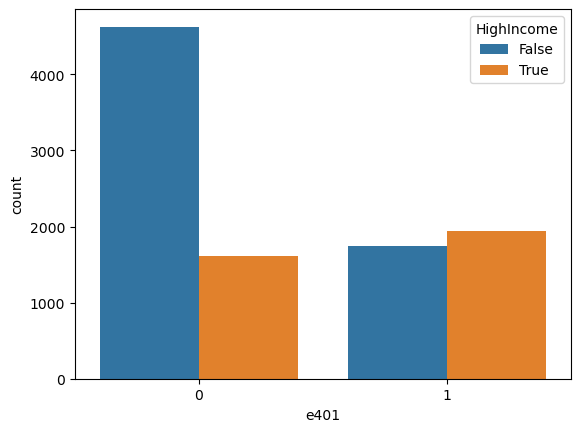

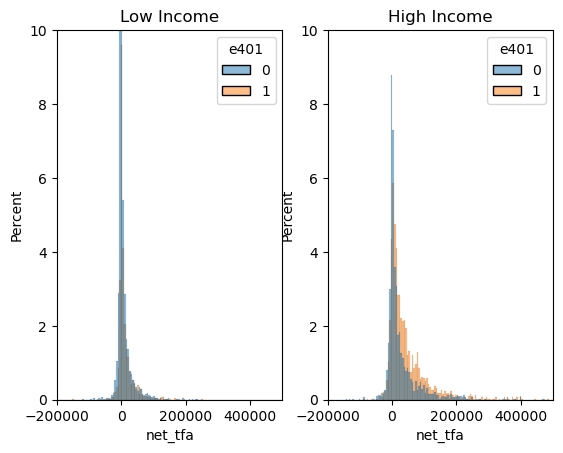

In [4]:
### Since we'll be analyzing the effect of 401k by income group we should consider the number of samples per group, and the split.
sns.countplot(data, x='e401', hue = 'HighIncome')
plt.show()

fig, axes = plt.subplots(1, 2)
inelPlot = sns.histplot(data= data[data['HighIncome'] == False], x='net_tfa', hue='e401', fill=True, stat = 'percent', ax = axes[0], binwidth=5000)
elPlot = sns.histplot(data=data[data['HighIncome'] == True], x='net_tfa', hue='e401', fill=True, stat = 'percent', ax = axes[1], binwidth=5000)
inelPlot.set(title="Low Income", ybound=[0,10], xbound = [-2e5,5e5])
elPlot.set(title="High Income", ybound=[0,10], xbound = [-2e5,5e5])
plt.show()

#### Fit the models as in the example, but now with GATE scores instead
The GATE score is actually the same as regressing the $\theta$ parameter on the subset of residualized data that is in group. Nuisance estimation is best done on the whole group. Since the method is rather simple, but running models takes some time we here only cover three of the 
high performing models under the partially linear model.

In [ ]:
### Now let's fit prediction models for D by the other variables X m(X)

# Borrow the transformer, dml wrapper and fitting from the example notebook
class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula, array=False):
        self.formula = formula
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        if self.array:
            return df.values
        return df
    
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown")

def dml(X,D,y,selec, modely, modeld, *, nfolds, classifier=False):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    resy: the outcome residuals
    resD: the treatment residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    # final stage ols based point estimate and standard error
    point = np.mean(resy[selec] * resD[selec]) / np.mean(resD[selec]**2)
    epsilon = resy[selec] - point * resD[selec]
    var = np.mean(epsilon**2 * resD[selec]**2) / np.mean(resD[selec]**2)**2
    stderr = np.sqrt(var / X[selec].shape[0])

    return point, stderr, yhat, Dhat, resy, resD, epsilon

def summary(point, stderr, yhat, Dhat, resy, resD, epsilon, X, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)),  # RMSE of model that predicts treatment D
                         'accuracy D': np.mean(np.abs(resD) < .5),  # binary classification accuracy of model for D
                         }, index=[name])

y = data['net_tfa'].values
D = data['e401'].values
D2 = data['p401'].values
D3 = data['a401'].values
X = data.drop(['e401', 'p401', 'a401', 'tw', 'tfa', 'net_tfa', 'tfa_he',
               'hval', 'hmort', 'hequity',
               'nifa', 'net_nifa', 'net_n401', 'ira',
               'dum91', 'icat', 'ecat', 'zhat',
               'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7',
               'a1', 'a2', 'a3', 'a4', 'a5'], axis=1)

# For simplicity and speed we'll only compare three of the well performing models in the partially linear model
# Double Lasso
selecR = X['HighIncome'] == True
selecP = X['HighIncome'] == False

cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lassod = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
resultP = dml(X,D,y,selecP, lassoy, lassod, nfolds=5)
resultR = dml(X,D,y,selecR, lassoy, lassod, nfolds=5) 
table = summary(*resultP, X[selecP], D[selecP], y[selecP], name='double lasso, Low Income') #type:ignore
table = pd.concat([table,summary(*resultR, X[selecR], D[selecR], y[selecR], name='double lasso, High Income')]) #type:ignore

# Random Forest
rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
resultP = dml(X,D,y,selecP, rfy, rfd, nfolds=5, classifier=True)
resultR = dml(X,D,y,selecR, rfy, rfd, nfolds=5, classifier=True)
table = pd.concat([table, summary(*resultP, X[selecP], D[selecP], y[selecP], name='double lasso, Low Income')])#type:ignore
table = pd.concat([table, summary(*resultR, X[selecR], D[selecR], y[selecR], name='double lasso, High Income')])#type:ignore

# Gradient Boost
gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
resultR = dml(X,D,y,selecR, gbfy, gbfd, nfolds=5, classifier=True)
resultP = dml(X,D,y,selecP, gbfy, gbfd, nfolds=5, classifier=True)
table = pd.concat([table, summary(*resultP, X[selecP], D[selecP], y[selecP], name='boosted forest, Low Income')])#type:ignore
table = pd.concat([table, summary(*resultR, X[selecR], D[selecR], y[selecR], name='boosted forest, High Income')])#type:ignore

table


,estimate,stderr,lower,upper,rmse y,rmse D,accuracy D
"double lasso, Low Income",4732.587643,986.162655,2799.708839,6665.466447,54254.468883,0.443406,0.688553
"double lasso, High Income",14773.717304,2715.692128,9450.960733,20096.473875,54254.468883,0.443406,0.688553
"double lasso, Low Income",4796.375459,976.931004,2881.590691,6711.160226,55236.824947,0.444551,0.688250
"double lasso, High Income",14289.982518,2886.596639,8632.253106,19947.711930,54981.004524,0.444613,0.687746
"boosted forest, Low Income",4871.368869,986.737317,2937.363727,6805.374011,55576.422627,0.443420,0.690368
"boosted forest, High Income",14083.273937,2845.049746,8506.976435,19659.571439,56094.044953,0.443561,0.689561
